In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [8]:
def rca_create_clutter_map(filename):
    '''Creates a clutter map (precip-free day) to be used for the RCA calculation for PPIs'''
    radar = pyart.aux_io.read_gamic(filename, file_field_names=True) 
    #radar = pyart.io.cfradial.read_cfradial(filename)
    date_time = radar.time['units'].replace('seconds since ', '')
    
    # Constrain range between 1 - 5 km
    #r_start_idx = np.where(radar.range['data'] < 1000.)[0][-1]+1
    r_start_idx = 0
    r_stop_idx = np.where(radar.range['data'] > 10000.)[0][0]
    
    # Using lowest elevation angle of PPI (0.5 deg)
    sweep_start_idx = radar.sweep_start_ray_index['data'][0]
    sweep_stop_idx = radar.sweep_end_ray_index['data'][0]+1
    
    # Get variables (only the rays/gates needed)
    zh = radar.fields['Zh']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zv = radar.fields['Zv']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    uzh = radar.fields['UZh']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    uzv = radar.fields['UZv']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    r = radar.range['data'][r_start_idx:r_stop_idx]
    theta = radar.azimuth['data'][sweep_start_idx:sweep_stop_idx]
    
    # Eliminate duplicate azimuths to maintain a total # of azimuths of 360
    if len(theta) > 360:
        diff = len(theta) - 360
        uzh = np.delete(uzh,-diff,axis=0)
        uzv = np.delete(uzv,-diff,axis=0)
        zh = np.delete(zh,-diff,axis=0)
        zv = np.delete(zv,-diff,axis=0)
        theta = np.delete(theta,-diff)
        
    # Arrange/sort azimuths to span 0 to 360 deg. from index 0 to 359
    sorted_idx = np.argsort(theta)
    zh = zh[sorted_idx,:]
    zv = zv[sorted_idx,:]
    uzh = uzh[sorted_idx,:]
    uzv = uzv[sorted_idx,:]
    theta = theta[sorted_idx]
    
    # Create a fixed polar grid/array (FPG; 1 deg x 1 km) and create mask to flag clutter
    r_grid = np.array((0,1,2,3,4,5,6,7,8,9,10))*1000.
    theta_grid = theta
    r_matrix, theta_matrix = np.meshgrid(r_grid,theta_grid)
    clutter_flag = np.zeros((r_matrix.shape))
    clutter_flag_v = np.zeros((r_matrix.shape))
    clutter_flag_uh = np.zeros((r_matrix.shape))
    clutter_flag_uv = np.zeros((r_matrix.shape))
    
    # Set reflectivity threshold 55 dBZ
    # Flag PPI pixels in FPG box that exceed threshold
    z_thresh = 45.
    zv_thresh = 45.
    
    # H POLARIZATION
    # Create an empty array to fill with Z from the clutter area reflectivity grid boxes (CAR)
    zh_car = np.empty((zh.shape))
    zh_car[:,:] = np.nan

    for i in range(0,len(theta_matrix[:,0])):
        for j in range(0,len(r_matrix[0,:])):
            if j == 0:
                clutter_flag[:,0] = np.nan
            else:
                if np.logical_or(zh[i,j*10-10] >= z_thresh, zh[i,j*10-9] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-8] >= z_thresh, zh[i,j*10-7] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-6] >= z_thresh, zh[i,j*10-5] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-4] >= z_thresh, zh[i,j*10-3] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-2] >= z_thresh, zh[i,j*10-1] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                else:
                    clutter_flag[i,j] = 0
                    
    # UH POLARIZATION
    # Create an empty array to fill with Z from the clutter area reflectivity grid boxes (CAR)
    uzh_car = np.empty((uzh.shape))
    uzh_car[:,:] = np.nan

    for i in range(0,len(theta_matrix[:,0])):
        for j in range(0,len(r_matrix[0,:])):
            if j == 0:
                clutter_flag_uh[:,0] = np.nan
            else:
                if np.logical_or(uzh[i,j*10-10] >= z_thresh, uzh[i,j*10-9] >= z_thresh):
                    clutter_flag_uh[i,j] = 1
                    uzh_car[i,j*10-10:j*10-1] = uzh[i,j*10-10:j*10-1]
                elif np.logical_or(uzh[i,j*10-8] >= z_thresh, uzh[i,j*10-7] >= z_thresh):
                    clutter_flag_uh[i,j] = 1
                    uzh_car[i,j*10-10:j*10-1] = uzh[i,j*10-10:j*10-1]
                elif np.logical_or(uzh[i,j*10-6] >= z_thresh, uzh[i,j*10-5] >= z_thresh):
                    clutter_flag_uh[i,j] = 1
                    uzh_car[i,j*10-10:j*10-1] = uzh[i,j*10-10:j*10-1]
                elif np.logical_or(uzh[i,j*10-4] >= z_thresh, uzh[i,j*10-3] >= z_thresh):
                    clutter_flag_uh[i,j] = 1
                    uzh_car[i,j*10-10:j*10-1] = uzh[i,j*10-10:j*10-1]
                elif np.logical_or(uzh[i,j*10-2] >= z_thresh, uzh[i,j*10-1] >= z_thresh):
                    clutter_flag_uh[i,j] = 1
                    uzh_car[i,j*10-10:j*10-1] = uzh[i,j*10-10:j*10-1]
                else:
                    clutter_flag_uh[i,j] = 0
                    
    # V POLARIZATION
    # Create an empty array to fill with Z from the clutter area reflectivity grid boxes (CAR)
    zv_car = np.empty((zv.shape))
    zv_car[:,:] = np.nan

    for i in range(0,len(theta_matrix[:,0])):
        for j in range(0,len(r_matrix[0,:])):
            if j == 0:
                clutter_flag_v[:,0] = np.nan
            else:
                if np.logical_or(zv[i,j*10-10] >= zv_thresh, zv[i,j*10-9] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                elif np.logical_or(zv[i,j*10-8] >= zv_thresh, zv[i,j*10-7] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                elif np.logical_or(zv[i,j*10-6] >= zv_thresh, zv[i,j*10-5] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                elif np.logical_or(zv[i,j*10-4] >= zv_thresh, zv[i,j*10-3] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                elif np.logical_or(zv[i,j*10-2] >= zv_thresh, zv[i,j*10-1] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                else:
                    clutter_flag_v[i,j] = 0
    # UV POLARIZATION
    # Create an empty array to fill with Z from the clutter area reflectivity grid boxes (CAR)
    uzv_car = np.empty((uzv.shape))
    uzv_car[:,:] = np.nan

    for i in range(0,len(theta_matrix[:,0])):
        for j in range(0,len(r_matrix[0,:])):
            if j == 0:
                clutter_flag_uv[:,0] = np.nan
            else:
                if np.logical_or(uzv[i,j*10-10] >= zv_thresh, uzv[i,j*10-9] >= zv_thresh):
                    clutter_flag_uv[i,j] = 1
                    uzv_car[i,j*10-10:j*10-1] = uzv[i,j*10-10:j*10-1]
                elif np.logical_or(uzv[i,j*10-8] >= zv_thresh, uzv[i,j*10-7] >= zv_thresh):
                    clutter_flag_uv[i,j] = 1
                    uzv_car[i,j*10-10:j*10-1] = uzv[i,j*10-10:j*10-1]
                elif np.logical_or(uzv[i,j*10-6] >= zv_thresh, uzv[i,j*10-5] >= zv_thresh):
                    clutter_flag_uv[i,j] = 1
                    uzv_car[i,j*10-10:j*10-1] = uzv[i,j*10-10:j*10-1]
                elif np.logical_or(uzv[i,j*10-4] >= zv_thresh, uzv[i,j*10-3] >= zv_thresh):
                    clutter_flag_uv[i,j] = 1
                    uzv_car[i,j*10-10:j*10-1] = uzv[i,j*10-10:j*10-1]
                elif np.logical_or(uzv[i,j*10-2] >= zv_thresh, uzv[i,j*10-1] >= zv_thresh):
                    clutter_flag_uv[i,j] = 1
                    uzv_car[i,j*10-10:j*10-1] = uzv[i,j*10-10:j*10-1]
                else:
                    clutter_flag_uv[i,j] = 0
    
    del radar
    return clutter_flag_uh, clutter_flag_uv, clutter_flag, clutter_flag_v, r_matrix, theta_matrix, uzh, uzv, zh, zv, uzh_car, uzv_car, zh_car, zv_car, date_time

In [9]:
# Run this function on a bunch of files (try data from one day)
import os
import glob
import scipy.stats as stats
from scipy.stats import norm 

clutter_flag_uh = []
clutter_flag_uv = []
clutter_flag = []
clutter_flag_v = []
theta = []
r = []
uzh = []
uzhCAR = []
uzv = []
uzvCAR = []
zh = []
zhCAR = []
zv = []
zvCAR = []
dt = []

for f in glob.glob(os.path.join('/run/media/hunzinger/WININSTALL/csapr2-data/', 'corcsapr*.*cor-ppi*20181108*.h5')):
    print(f)
    ClutterFlagUH, ClutterFlagUV, ClutterFlag, ClutterFlagV, R, Theta, UZH, UZV, ZH, ZV, UZHCAR, UZVCAR, ZHCAR, ZVCAR, DateTime = rca_create_clutter_map(f)
    
    # Put all PPI times into a list
    clutter_flag_uh.append(ClutterFlagUH)
    clutter_flag_uv.append(ClutterFlagUV)
    clutter_flag.append(ClutterFlag)
    clutter_flag_v.append(ClutterFlagV)
    r.append(R)
    theta.append(Theta)
    uzh.append(UZH)
    uzhCAR.append(UZHCAR)
    zh.append(ZH)
    zhCAR.append(ZHCAR)
    uzv.append(UZV)
    uzvCAR.append(UZVCAR)
    zv.append(ZV)
    zvCAR.append(ZVCAR)
    dt.append(DateTime)



/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.011001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108000003_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.021001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108001503_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.021001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108003003_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.021001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108004503_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.021001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108010003_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.031001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108011503_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.031001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108013003_00.h5
/run/media/hunzinger/WININSTALL/csapr2-data/corcsaprM1.00.20181108.031001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181

Clutter flag shape (58, 360, 11)
PCT_on_50 shape (360, 11)
PCT_on_50 (11,)
PCT (101,)
R shape (360, 101)


/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


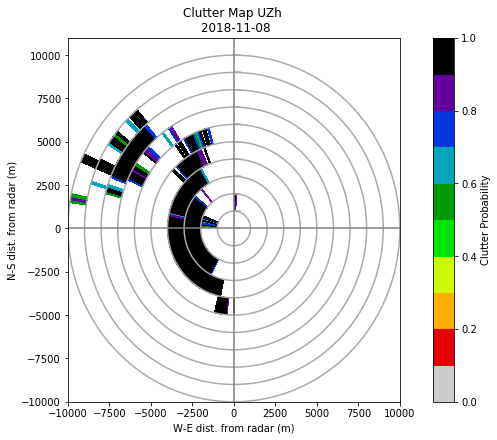

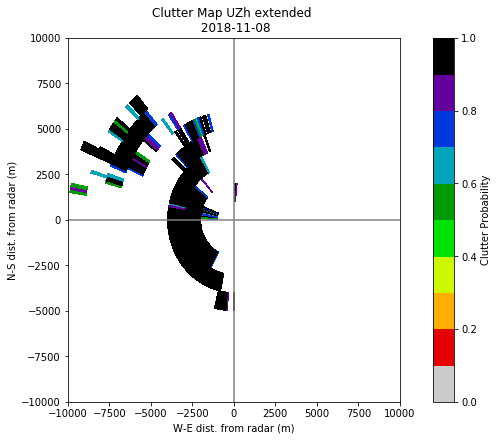

In [52]:
#UZh
clutter_flag_uh = np.asarray(clutter_flag_uh)
print('Clutter flag shape',clutter_flag_uh.shape)
#print('Clutter flag',clutter_flag_uh)
uhPCT_on = np.sum(clutter_flag_uh,axis=0)/len(clutter_flag_uh[:,0,0])
# Mask values less than 0.5
mask_u50 = np.where(uhPCT_on <= 0.5)
uhPCT_on_50 = np.copy(uhPCT_on)
uhPCT_on_50[mask_u50] = np.nan
print('PCT_on_50 shape', uhPCT_on_50.shape)
print('PCT_on_50', uhPCT_on_50[280,:].shape)

# Match dimensions of PCT_on
uhPCT = np.empty((360,101))
for i in range(0,len(uhPCT[:,0])):
    uhPCT[i,:] = np.repeat(uhPCT_on_50[i,:],10)[:-9]
    
print('PCT', uhPCT[0,:].shape)
uhmask = np.isfinite(uhPCT)
#print('Mask', uhmask[280,:])

rr = np.arange(101)*100
R, TH = np.meshgrid(rr,theta[0][:,0])
print('R shape',R.shape)
# Plot clutter map
from matplotlib.colors import BoundaryNorm
# Convert to cartesian coords to plot
x = (r[0]*np.sin(theta[0]*np.pi/180.))
y = (r[0]*np.cos(theta[0]*np.pi/180.))
xx = (R*np.sin(TH*np.pi/180.))
yy = (R*np.cos(TH*np.pi/180.))
#levels = np.arange(6)/10+0.5
levels = np.arange(11)/10
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('nipy_spectral_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-10000,10000,color='grey')
ax1.axhline(0,-10000,10000,color='grey')
im = ax1.pcolormesh(x, y, uhPCT_on_50, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map UZh \n 2018-11-08')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')
plt.show()

#print(xx[1])
#print(yy[0])
#print(rr)

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
#ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-10000,10000,color='grey')
ax1.axhline(0,-10000,10000,color='grey')
im = ax1.pcolormesh(xx, yy, uhPCT, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map UZh extended \n 2018-11-08')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')
plt.show()

(58, 360, 11)
(360, 11)
hPCT (360, 101)
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan]
R shape (360, 101)


/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """


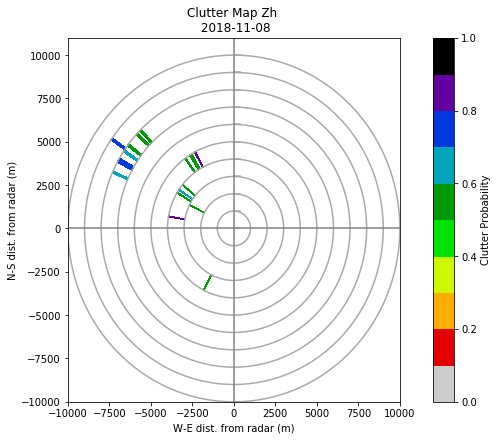

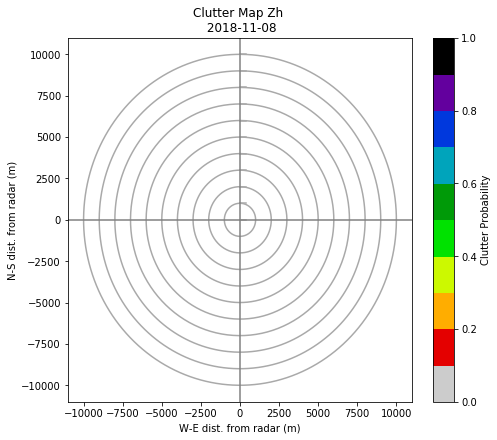

(58, 360, 11)
(360, 11)


/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less_equal


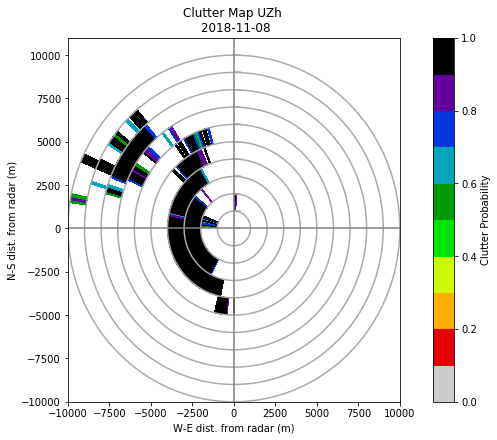

(58, 360, 11)
(360, 11)


/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in less_equal


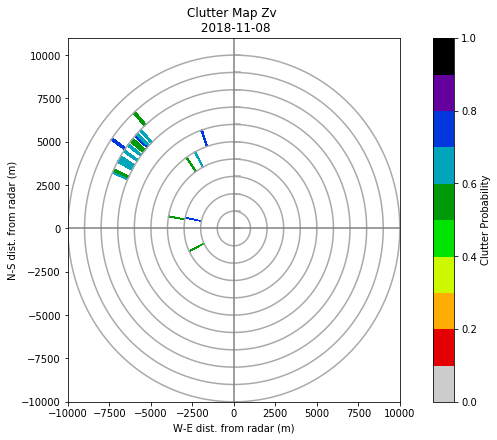

(58, 360, 11)
(360, 11)


/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in less_equal


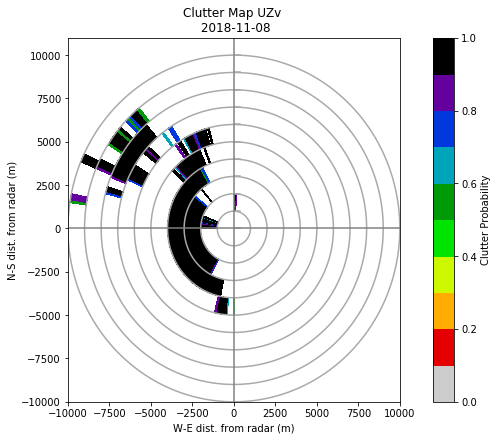

[    0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000.
 10000.]


In [30]:
clutter_flag = np.asarray(clutter_flag)
print(clutter_flag.shape)
PCT_on = np.sum(clutter_flag,axis=0)/len(clutter_flag[:,0,0])
# Mask values less than 0.5
mask_u50 = np.where(PCT_on <= 0.5)
PCT_on_50 = np.copy(PCT_on)
PCT_on_50[mask_u50] = np.nan
print(PCT_on_50.shape)

# Match dimensions of PCT_on
hPCT = np.empty((360,101))
for i in range(0,len(hPCT[:,0])):
    hPCT[i,:] = np.repeat(PCT_on_50[i,:],10)[:-9]
hmask = np.isfinite(hPCT)

print('hPCT', hPCT.shape)
print(hPCT[275,:])

rr = np.arange(101)*100
R, TH = np.meshgrid(rr,theta[0][:,0])
print('R shape',R.shape)
# Plot clutter map
from matplotlib.colors import BoundaryNorm
# Convert to cartesian coords to plot
x = (r[0]*np.sin(theta[0]*np.pi/180.))
y = (r[0]*np.cos(theta[0]*np.pi/180.))
xx = (R*np.sin(TH[0]*np.pi/180.))
yy = (R*np.cos(TH[0]*np.pi/180.))
#levels = np.arange(6)/10+0.5
levels = np.arange(11)/10
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('nipy_spectral_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-10000,10000,color='grey')
ax1.axhline(0,-10000,10000,color='grey')
im = ax1.pcolormesh(x, y, PCT_on_50, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map Zh \n 2018-11-08')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')
plt.show()

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-10000,10000,color='grey')
ax1.axhline(0,-10000,10000,color='grey')
im = ax1.pcolormesh(xx, yy, hPCT, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map Zh \n 2018-11-08')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')
plt.show()

#UZh
clutter_flag_uh = np.asarray(clutter_flag_uh)
print(clutter_flag_uh.shape)
uhPCT_on = np.sum(clutter_flag_uh,axis=0)/len(clutter_flag_uh[:,0,0])
# Mask values less than 0.5
mask_u50 = np.where(uhPCT_on <= 0.5)
uhPCT_on_50 = np.copy(uhPCT_on)
uhPCT_on_50[mask_u50] = np.nan
print(uhPCT_on_50.shape)

# Match dimensions of PCT_on
uhPCT = np.empty((360,101))
for i in range(0,len(uhPCT[:,0])):
    uhPCT[i,:] = np.repeat(uhPCT_on_50[i,:],10)[:-9]
uhmask = np.isfinite(uhPCT)


fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-10000,10000,color='grey')
ax1.axhline(0,-10000,10000,color='grey')
im = ax1.pcolormesh(x, y, uhPCT_on_50, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map UZh \n 2018-11-08')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')
plt.show()

# V POLARIZATION
clutter_flag_v = np.asarray(clutter_flag_v)
print(clutter_flag_v.shape)
vPCT_on = np.sum(clutter_flag_v,axis=0)/len(clutter_flag_v[:,0,0])
# Mask values less than 0.5
mask_u50 = np.where(vPCT_on <= 0.5)
vPCT_on_50 = np.copy(vPCT_on)
vPCT_on_50[mask_u50] = np.nan
print(vPCT_on_50.shape)

# Match dimensions of PCT_on
vPCT = np.empty((360,101))
for i in range(0,len(vPCT[:,0])):
    vPCT[i,:] = np.repeat(vPCT_on_50[i,:],10)[:-9]
vmask = np.isfinite(vPCT)

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-10000,10000,color='grey')
ax1.axhline(0,-10000,10000,color='grey')
im = ax1.pcolormesh(x, y, vPCT_on_50, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map Zv \n 2018-11-08')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')
plt.show()

#UZv
clutter_flag_uv = np.asarray(clutter_flag_uv)
print(clutter_flag_uv.shape)
uvPCT_on = np.sum(clutter_flag_uv,axis=0)/len(clutter_flag_uv[:,0,0])
# Mask values less than 0.5
mask_u50 = np.where(uvPCT_on <= 0.5)
uvPCT_on_50 = np.copy(uvPCT_on)
uvPCT_on_50[mask_u50] = np.nan
print(uvPCT_on_50.shape)

# Match dimensions of PCT_on
uvPCT = np.empty((360,101))
for i in range(0,len(uvPCT[:,0])):
    uvPCT[i,:] = np.repeat(uvPCT_on_50[i,:],10)[:-9]
uvmask = np.isfinite(uvPCT)

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-10000,10000,color='grey')
ax1.axhline(0,-10000,10000,color='grey')
im = ax1.pcolormesh(x, y, uvPCT_on_50, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map UZv \n 2018-11-08')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')
plt.show()

print(r[0][0])

In [54]:
from netCDF4 import Dataset
dataset = Dataset('/home/hunzinger/data/rca_cluttermap_20181108.nc',
                  'w',format='NETCDF4_CLASSIC')
azi = dataset.createDimension('azi', 360)
rang = dataset.createDimension('rang', 11)
value = dataset.createDimension('value',1)
zrang = dataset.createDimension('zrang',101)


#PCT_ON_50 = dataset.createVariable('clutter_gate_values_zh', np.float64, ('azi','rang'))
#vPCT_ON_50 = dataset.createVariable('clutter_gate_values_zv', np.float64, ('azi','rang'))
#uhPCT_ON_50 = dataset.createVariable('clutter_gate_values_uzh', np.float64, ('azi','rang'))
#uvPCT_ON_50 = dataset.createVariable('clutter_gate_values_uzv', np.float64, ('azi','rang'))
HMASK = dataset.createVariable('clutter_gate_mask_zh', 'i1', ('azi','zrang'))
VMASK = dataset.createVariable('clutter_gate_mask_zv', 'i1', ('azi','zrang'))
UHMASK = dataset.createVariable('clutter_gate_mask_uzh', 'i1', ('azi','zrang'))
UVMASK = dataset.createVariable('clutter_gate_mask_uzv', 'i1', ('azi','zrang'))
PCT_ON_50 = dataset.createVariable('clutter_gate_values_zh', np.float64, ('azi','zrang'))
vPCT_ON_50 = dataset.createVariable('clutter_gate_values_zv', np.float64, ('azi','zrang'))
uhPCT_ON_50 = dataset.createVariable('clutter_gate_values_uzh', np.float64, ('azi','zrang'))
uvPCT_ON_50 = dataset.createVariable('clutter_gate_values_uzv', np.float64, ('azi','zrang'))

PCT_ON_50.long_name = 'Flagged clutter grid gates (Zh)'
vPCT_ON_50.long_name = 'Flagged clutter grid gates (Zv)'
uhPCT_ON_50.long_name = 'Flagged clutter grid gates (UZh)'
uvPCT_ON_50.long_name = 'Flagged clutter grid gates (UZv)'
HMASK.long_name = 'Flagged clutter grid mask (Zh)'
VMASK.long_name = 'Flagged clutter grid mask (Zv)'
UHMASK.long_name = 'Flagged clutter grid mask (UZh)'
UVMASK.long_name = 'Flagged clutter grid mask (UZv)'

#PCT_ON_50[:,:] = PCT_on_50
#vPCT_ON_50[:,:] = vPCT_on_50
#uhPCT_ON_50[:,:] = uhPCT_on_50
#uvPCT_ON_50[:,:] = uvPCT_on_50
PCT_ON_50[:,:] = hPCT
vPCT_ON_50[:,:] = vPCT
uhPCT_ON_50[:,:] = uhPCT
uvPCT_ON_50[:,:] = uvPCT
HMASK[:,:] = hmask
VMASK[:,:] = vmask
UHMASK[:,:] = uhmask
UVMASK[:,:] = uvmask

dataset.close()